# Python: Conditional Average Treatment Effects (CATEs) for IRM models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate conditional average treatment effects with B-splines for one or two-dimensional effects in the [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) model.

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html) and this [notebook](https://github.com/py-why/EconML/blob/main/notebooks/Causal%20Forest%20and%20Orthogonal%20Random%20Forest%20Examples.ipynb) from [EconML](https://github.com/py-why/EconML).

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

The data is generated as

$$
\begin{aligned}
Y_i & = g(X_i)T_i + \langle W_i,\gamma_0\rangle + \epsilon_i \\
T_i & = 1_{\{\langle W_i,\beta_0\rangle \ge \eta_i\}},
\end{aligned}
$$

where $W_i\sim\mathcal{N}(0,I_{d_w})$, $X_i\sim\mathcal{U}[0,1]^{d_x}$ and $\epsilon_i,\eta_i\sim\mathcal{U}[-1,1]$.
The coefficient vectors $\gamma_0$ and $\beta_0$ both have small random support which values are drawn independently from $\mathcal{U}[0,1]$ and $\mathcal{U}[0,0.3]$.
Further, $g(x)$ defines the conditional treatment effect, which is defined differently depending on the dimension of $x$.

If $x$ is univariate the conditional treatment effect takes the following form

$$ g(x) = \exp(2x) + 3\sin(4x),$$

whereas for a two-dimensional variable $x=(x_1,x_2)$ the conditional treatment effect is defined as

$$ g(x) = \exp(2x_1) + 3\sin(4x_2).$$

In [2]:
def treatment_effect_1d(x):
    te = np.exp(2 * x) + 3 * np.sin(4 * x)
    return te

def treatment_effect_2d(x):
    te = np.exp(2 * x[0]) + 3 * np.sin(4 * x[1])
    return te

def create_synthetic_data(n_samples=200, n_w=30, support_size=5, n_x=1):
    # Outcome support
    # With the next two lines we are effectively choosing the matrix gamma in the example
    support_y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_y = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)
    # Treatment support
    # Assuming the matrices gamma and beta have the same non-zero components
    support_t = support_y
    coefs_t = np.random.uniform(0, 0.3, size=support_size)
    # Define the function to generate the noise
    eta_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)

    # Generate controls, covariates, treatments and outcomes
    w = np.random.normal(0, 1, size=(n_samples, n_w))
    x = np.random.uniform(0, 1, size=(n_samples, n_x))
    # Heterogeneous treatment effects
    if n_x == 1:
        te = np.array([treatment_effect_1d(x_i) for x_i in x]).reshape(-1)
    elif n_x == 2:
        te = np.array([treatment_effect_2d(x_i) for x_i in x]).reshape(-1)
    # Define treatment
    t = 1.0 * (np.dot(w[:, support_t], coefs_t) >= eta_sample(n_samples))
    # Define the outcome
    y = te * t + np.dot(w[:, support_y], coefs_y) + epsilon_sample(n_samples)

    # Now we build the dataset
    y_df = pd.DataFrame({'y': y})
    if n_x == 1:
        x_df = pd.DataFrame({'x': x.reshape(-1)})
    elif n_x == 2:
        x_df = pd.DataFrame({'x_0': x[:,0],
                             'x_1': x[:,1]})
    t_df = pd.DataFrame({'t': t})
    w_df = pd.DataFrame(data=w, index=np.arange(w.shape[0]), columns=[f'w_{i}' for i in range(w.shape[1])])

    data = pd.concat([y_df, x_df, t_df, w_df], axis=1)

    covariates = list(w_df.columns.values) + list(x_df.columns.values)
    return data, covariates, te

## One-dimensional Example

We start with $X$ being one-dimensional and create our training data.

In [3]:
# DGP constants
np.random.seed(42)
n_samples = 2000
n_w = 10
support_size = 5
n_x = 1

# Create data
data, covariates, true_effect = create_synthetic_data(n_samples=n_samples, n_w=n_w, support_size=support_size, n_x=n_x)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='y',
                                 d_cols='t',
                                 x_cols=covariates)

Next, define the learners for the nuisance functions and fit the [IRM Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html). Remark that the learners are not optimal for the linear form of this example.

In [4]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

print(dml_irm.summary)

Training IRM Model
       coef   std err          t  P>|t|    2.5 %    97.5 %
t  4.476786  0.042637  104.99785    0.0  4.39322  4.560353


To estimate the CATE, we rely on the best-linear-predictor of the linear score as in [Semenova et al. (2021)](https://doi.org/10.1093/ectj/utaa027) To approximate the target function $g(x)$ with a linear form, we have to define a data frame of basis functions. Here, we rely on [patsy](https://patsy.readthedocs.io/en/latest/) to construct a suitable basis of [B-splines](https://en.wikipedia.org/wiki/B-spline).

In [5]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=2)", {"x":data["x"]})
spline_basis = pd.DataFrame(design_matrix)

To estimate the parameters to calculate the CATE estimate call the ``cate()`` method and supply the dataframe of basis elements.

In [6]:
cate = dml_irm.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t          P>|t|    [0.025    0.975]
0  1.092174  0.179573   6.082056   1.418457e-09  0.740004  1.444345
1  1.889445  0.300066   6.296760   3.728087e-10  1.300969  2.477921
2  4.387543  0.191823  22.872843  5.117109e-103  4.011348  4.763738
3  4.220256  0.229626  18.378861   8.152105e-70  3.769925  4.670588
4  3.702028  0.235897  15.693433   2.011671e-52  3.239398  4.164658
5  3.723392  0.255678  14.562813   9.886153e-46  3.221967  4.224816


To obtain the confidence intervals for the CATE, we have to call the ``confint()`` method and a supply a dataframe of basis elements.
This could be the same basis as for fitting the CATE model or a new basis to e.g. evaluate the CATE model on a grid.
Here, we will evaluate the CATE on a grid from 0.1 to 0.9 to plot the final results.
Further, we construct uniform confidence intervals by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [7]:
new_data = {"x": np.linspace(0.1, 0.9, 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   2.200414  2.509108  2.817801
1   2.302866  2.614500  2.926135
2   2.401337  2.718511  3.035686
3   2.496944  2.821140  3.145336
4   2.590631  2.922386  3.254142
..       ...       ...       ...
95  4.560040  4.868832  5.177624
96  4.560756  4.861259  5.161763
97  4.561707  4.854249  5.146792
98  4.562063  4.847801  5.133540
99  4.560825  4.841916  5.123008

[100 rows x 3 columns]


Finally, we can plot our results and compare them with the true effect.

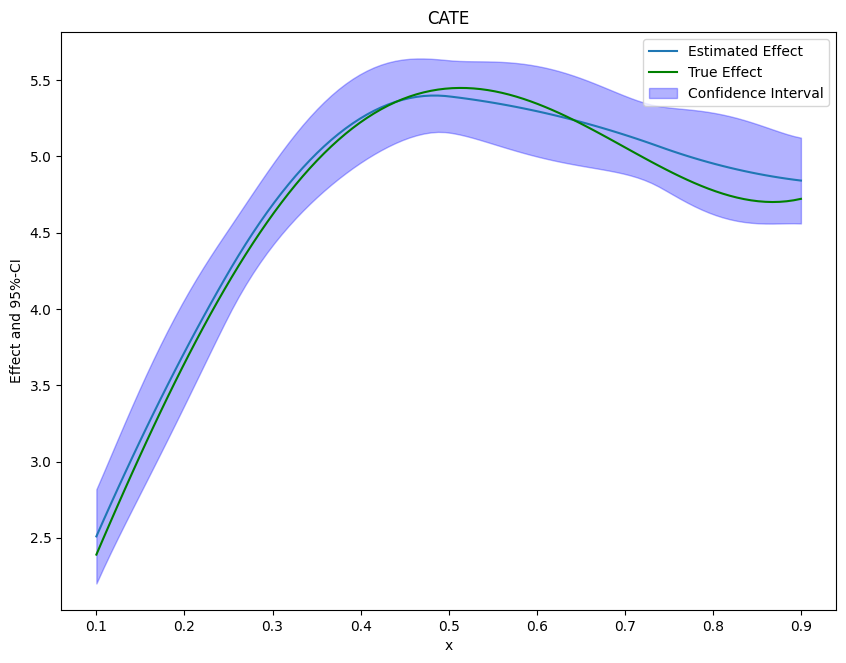

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['x']
df_cate['true_effect'] = treatment_effect_1d(new_data['x'])
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['true_effect'], color="green", label='True Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

## Two-Dimensional Example

It is also possible to estimate multi-dimensional conditional effects. We will use the same data-generating process as above, but let $X$ be two-dimensional.

In [9]:
# DGP constants
np.random.seed(42)
n_samples = 5000
n_w = 10
support_size = 5
n_x = 2

In [10]:
# Create data
data, covariates, true_effect = create_synthetic_data(n_samples=n_samples, n_w=n_w, support_size=support_size, n_x=n_x)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='y',
                                 d_cols='t',
                                 x_cols=covariates)

As univariate example estimate the [IRM Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html).

In [11]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(123)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

Training IRM Model


As above, we will rely on the [patsy](https://patsy.readthedocs.io/en/latest/) package to construct the basis elements.
In the two-dimensional case, we will construct a tensor product of B-splines (for more information see [here](https://patsy.readthedocs.io/en/latest/spline-regression.html#tensor-product-smooths)).

In [12]:
design_matrix = patsy.dmatrix("te(bs(x_0, df=7, degree=3), bs(x_1, df=7, degree=3))", {"x_0": data["x_0"], "x_1": data["x_1"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_irm.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
        coef   std err          t          P>|t|    [0.025     0.975]
0   2.721092  0.121918  22.319121  3.206284e-105  2.482080   2.960105
1  -3.824086  0.975964  -3.918263   9.039202e-05 -5.737408  -1.910763
2   2.986499  1.001745   2.981297   2.884281e-03  1.022635   4.950364
3   2.711858  0.862987   3.142408   1.685538e-03  1.020021   4.403696
4   0.400103  0.888521   0.450302   6.525126e-01 -1.341792   2.141997
5  -2.774071  1.076680  -2.576505   1.000918e-02 -4.884841  -0.663301
6  -4.422706  1.162242  -3.805322   1.433291e-04 -6.701216  -2.144196
7  -6.717092  1.253702  -5.357804   8.805597e-08 -9.174904  -4.259279
8   0.752585  1.044202   0.720727   4.711115e-01 -1.294515   2.799684
9  -0.448983  1.087713  -0.412777   6.797876e-01 -2.581384   1.683417
10  1.862309  0.894545   2.081851   3.740737e-02  0.108604   3.616014
11  1.067676  0.929907   1.148154   2.509607e-01 -0.

Finally, we create a new grid to evaluate and plot the effects.

In [13]:
grid_size = 100
x_0 = np.linspace(0.1, 0.9, grid_size)
x_1 = np.linspace(0.1, 0.9, grid_size)
x_0, x_1 = np.meshgrid(x_0, x_1)

new_data = {"x_0": x_0.ravel(), "x_1": x_1.ravel()}

In [14]:
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, joint=True, n_rep_boot=2000)
print(df_cate)

         2.5 %    effect    97.5 %
0     1.185405  1.944154  2.702902
1     1.253345  1.976245  2.699145
2     1.331445  2.016942  2.702439
3     1.414889  2.065072  2.715255
4     1.498747  2.119459  2.740170
...        ...       ...       ...
9995  3.626073  4.406089  5.186104
9996  3.673094  4.479721  5.286348
9997  3.721382  4.552193  5.383003
9998  3.773369  4.623412  5.473456
9999  3.830872  4.693290  5.555708

[10000 rows x 3 columns]


In [15]:
import plotly.graph_objects as go

true_effect = np.array([treatment_effect_2d(x_i) for x_i in zip(x_0.ravel(), x_1.ravel())]).reshape(x_0.shape)
effect = np.asarray(df_cate['effect']).reshape(x_0.shape)
lower_bound = np.asarray(df_cate['2.5 %']).reshape(x_0.shape)
upper_bound = np.asarray(df_cate['97.5 %']).reshape(x_0.shape)

fig = go.Figure(data=[
    go.Surface(x=x_0,
               y=x_1,
               z=true_effect),
    go.Surface(x=x_0,
               y=x_1,
               z=upper_bound, showscale=False, opacity=0.4,colorscale='purp'),
    go.Surface(x=x_0,
               y=x_1,
               z=lower_bound, showscale=False, opacity=0.4,colorscale='purp'),
])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(scene = dict(
                    xaxis_title='X_0',
                    yaxis_title='X_1',
                    zaxis_title='Effect'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()